# 9.2 Gaussian discriminant analysis

## 9.2.1 Quadratic decision boundaries

> Author: Duane Rich, heavily modified by Kevin Murphy  
> Based on matlab code by Kevin Murphy  
> https://github.com/probml/pmtk3/blob/master/demos/discrimAnalysisDboundariesDemo.m

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Generate mean for multivariate gaussian
sample_size = 30

# # model1
# means = [[1.5, 1.5], [-1.5, -1.5]]
# covs = [np.eye(2)] * 2 # spherical covariances

# # model2
# means = [[1.5, 1.5], [-1.5, -1.5]]
# covs = [
#     [[1.5, 0], [0, 1]], # diagonal covariance
#     np.eye(2) * 0.7 # spherical covariance
# ]

# # model3
# means = [[0, 0], [0, 5], [5, 5]]
# covs = [np.eye(2)] * 3 # spherical covariances

# model4
means = [[0, 0], [0, 4], [4, 4]]
covs = [
    [[4, 1], [1, 2]], # full covariance
    [[2, 0], [0, 1]], # diagonal covariance
    [[1, 0], [0, 1]]  # spherical covariance
]

nclasses = len(means)
assert nclasses == len(covs)

In [19]:
# Generate random points for multivariate gaussian
rng = np.random.default_rng()
samples = [
    rng.multivariate_normal(mean, cov, size=sample_size) \
        for mean, cov in zip(means, covs)
]
labels = [np.full(sample_size, label) for label in range(nclasses)]

samples[0].shape, labels[0].shape

((30, 2), (30,))

In [20]:
# Maximum likelihood covariance estimator (biased)
from sklearn.covariance import empirical_covariance
# empirical_covariance(X) == np.cov(X, rowvar=False, bias=True)
[(np.array(cov), empirical_covariance(X), np.cov(X, rowvar=False, bias=False)) \
    for X, cov in zip(samples, covs)]

[(array([[4, 1],
         [1, 2]]),
  array([[4.16785509, 1.29619162],
         [1.29619162, 2.06632393]]),
  array([[4.31157424, 1.34088788],
         [1.34088788, 2.13757648]])),
 (array([[2, 0],
         [0, 1]]),
  array([[ 1.9044277 , -0.00542773],
         [-0.00542773,  0.76698765]]),
  array([[ 1.97009762, -0.0056149 ],
         [-0.0056149 ,  0.7934355 ]])),
 (array([[1, 0],
         [0, 1]]),
  array([[ 1.2201373 , -0.24525812],
         [-0.24525812,  0.88121755]]),
  array([[ 1.262211  , -0.25371529],
         [-0.25371529,  0.91160436]]))]

In [21]:
def make_grid(samples, ngrid=300):
    points = np.concatenate(samples, axis=0)
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy

xx, yy = make_grid(samples)
xy = np.stack((xx, yy), axis=-1)

xx.shape, yy.shape, xy.shape

((300, 300), (300, 300), (300, 300, 2))

### Figure 9.1: (a) Some 3d data from 3 different classes.

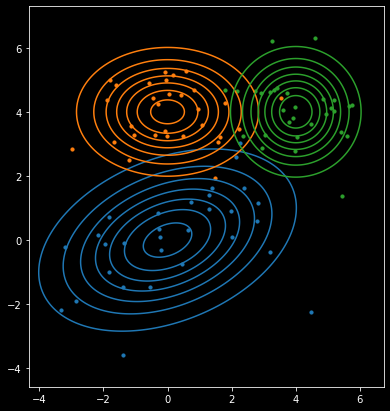

In [22]:
from scipy.stats import multivariate_normal
from matplotlib.colors import TABLEAU_COLORS

# plot points and coutours of multivariate gaussians
_, ax = plt.subplots(figsize=(7,7))
ax.set_aspect('equal')
for x, mean, cov, c in zip(samples, means, covs, TABLEAU_COLORS):
    ax.scatter(x[:, 0], x[:, 1], s=10, color=c)
    ax.contour(xx, yy, multivariate_normal.pdf(xy, mean=mean, cov=cov), colors=c)

### Figure 9.1: (b) Fitting 2d Gaussians to each class.

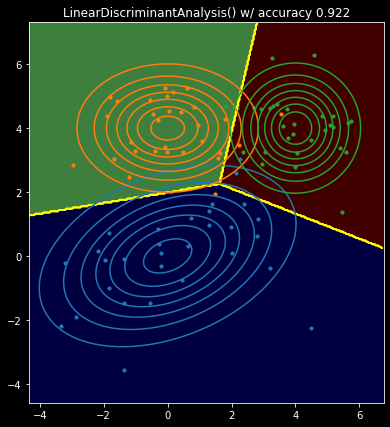

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

_, ax = plt.subplots(figsize=(7,7))
ax.set_aspect('equal')

# fit model with samples
clf = LinearDiscriminantAnalysis()
# clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
# reg_param controls between (unbiased) sample covariance (0) to the identity (1) 
X = np.concatenate(samples, axis=0) # shape (sample_size * nclasses, 2)
Y = np.concatenate(labels) # shape (sample_size * nclasses,)
clf.fit(X, Y)
ax.set_title(f"{clf} w/ accuracy {clf.score(X, Y):.3f}")

# plot boundaries
Z = clf.predict(np.stack((xx.ravel(), yy.ravel()), axis=-1)) # shape (sample_size * nclasses,)
ax.pcolormesh(xx, yy, Z.reshape(xx.shape), alpha=0.5, cmap='jet')
for z_p in OneHotEncoder(sparse=False).fit_transform(Z[:,np.newaxis]).T:
    ax.contour(xx, yy, z_p.reshape(xx.shape), levels=[0.5], linewidths=2, colors='yellow')

# plot points and coutours of multivariate gaussians
for x, mean, cov, c in zip(samples, means, covs, TABLEAU_COLORS):
    ax.scatter(x[:, 0], x[:, 1], s=10, color=c)
    ax.contour(xx, yy, multivariate_normal.pdf(xy, mean=mean, cov=cov), colors=c)